In [1]:
### Script computes the optimal battery dispatch given uncertain PV production and real-time prices using dynamic programming.
### Method is generalizable to different random states. 
### For larger problems, the approach could be optimized by parallelizing or vectorizing across all SOC states for each timestep.

In [2]:
import pandas as pd
import numpy as np
import os
import math
import itertools
import matplotlib.pyplot as plt

In [3]:
### Define wd and file names for reading
wd = 'C:\\Users\\DTRManning\\Desktop\\IndependentProjects\\LearningDP\\BatteryControl'

priceFname = 'RealTimePrice.csv'
pvFname    = 'PV_ProductionData_24hour.csv'

In [4]:
### Combine into absolute file paths
priceFpath = os.path.join( wd, priceFname )
pvFpath    = os.path.join( wd, pvFname )

In [5]:
### PV production is uncertain and described by different possible states
### Battery can only charge off PV production
### Real time price is also uncertain and described by two states for each interval.
### Settlement is Price * (PV - Charge + Discharge)

In [6]:
### Define battery parameters
maxEnergy = 5
minEnergy = 1

maxCharge    = 2
maxDischarge = 2

# Size of the transition step to discretize SOC states
transitionInterval = .25

In [7]:
### Read in price and PV production data.
priceData = pd.read_csv(priceFpath)
pvData    = pd.read_csv(pvFpath)

In [8]:
# pad an additional interval with zeros for last period of DP.
# df = df.append(pd.Series(0, index=df.columns), ignore_index=True)
pvData    = pvData.append( pd.Series(0, index = pvData.columns), ignore_index = True )
priceData = priceData.append( pd.Series(0, index = priceData.columns), ignore_index = True )

In [9]:
# Slicing examples because I always get confused between python and R.
#pvData[pvData['Time']==0]
#pvData.loc[0,'0.2']

In [10]:
### Convert PV and price data to long format, where each column has time, probability, and value
# For PV: selectKeys = ['PVLow','PVMid','PVHigh']; valueName = 'PVProduction_MW'
# For prices: selectKeys = ['Pos','Neg']; valueName = 'RealTimePrice'

def InputsWideToLong(wideDF,selectKeys,valueName):
    
    collectDFs = list() # Empty list for collecting subset dataframes

    for selectKey in selectKeys:

        selectCols = [col for col in wideDF if col.startswith(selectKey) or col == 'Time']

        ### Standardize column naming convention.
        curDF = wideDF[selectCols]
        curDF = curDF.assign(Scenario = selectKey)
        # Rename probability column to "Prob"
        curDF = curDF.rename(lambda x: 'Prob' if 'PROB' in x.upper() else x, axis=1)
        # Rename column to standardize naming convention across groups
        curDF = curDF.rename(columns ={ selectKey: valueName } )

        ### Collect in list
        collectDFs.append(curDF)

    ### Concatenate into a single dataframe.
    newDF = pd.concat(collectDFs)
    newDF = newDF[newDF['Prob'] > 0] # Only include probabilities greater than zero for parsimony
    # Round probabilities to 4 digits of precision
    newDF.Prob = newDF.Prob.round(4)

    
    return(newDF)

In [11]:
### For each timestep, create a dataframe that calculates the joint probability of permutations of different price and PV levels. Returns as dataframe. 
def GetJointProbabilities( pvData, priceData, timeStep ):
    
    # Prep price data for join
    curPVdata = pvData[pvData['Time']==timeStep]
    curPVdata = curPVdata.rename({'Prob':'PV_Prob'}, axis = 1)
    curPVdata['key'] = 0
    curPVdata = curPVdata.drop('Scenario', axis = 1)

    # Prep PV production data for join
    curPricedata = priceData[priceData['Time']==timeStep]
    curPricedata = curPricedata.rename({'Prob':'Price_Prob'}, axis = 1)
    curPricedata['key'] = 0
    curPricedata = curPricedata.drop('Scenario', axis = 1)
    curPricedata

    ### Build all scenarios for current timestep by combining all permutations and collect into rows of combined dataframe
    combinedData = curPVdata.merge(curPricedata, on = ['Time','key'])
    # Remove extraneous key and calculate join probabilities
    combinedData['Joint_Prob'] = combinedData['PV_Prob'] * combinedData['Price_Prob']
    combinedData               = combinedData.drop('key',axis=1)

    return(combinedData)

In [12]:
### Create a dictionary where the key is the timestep and each value is a dataframe with the joint PV production and price probabilities. 
def CollectJointProbsByT(pvData, priceData):
    
    # Calculate the joint probabilities for each timestep. Filter down to only the common timesteps
    sharedTimeSteps = np.intersect1d( pvData['Time'].unique(), priceData['Time'].unique() )
    # Create dictionary for collecting probabilities at each timestep
    AllTimeSteps = {}
    # Collect joint probabilities for all time steps
    for timeStep in sharedTimeSteps:
        AllTimeSteps[timeStep] = GetJointProbabilities( pvData, priceData, timeStep )

    return (AllTimeSteps)

In [13]:
def DiscretizeSOC( minEnergy, maxEnergy, transitionInterval ):
    
    ### Disretize battery SOC into intervals based on the transition interval size.
    socStates = np.arange(minEnergy, maxEnergy + transitionInterval, transitionInterval) # Add transition interval to include max SOC in states

    ### Create a transition matrix with the accessible states at each SOC. Structure as dictionary of transition vectors for 
    ### fast lookup.
    TransitionVectors = {}

    for curState in socStates:

        # For each state, calculate the distances to see which states are accessible. Battery SOC can't decrease more than 
        # maxDischarge or increase more than maxCharge.
        availableStates = pd.DataFrame( {'AllStates': socStates} )
        availableStates['distance'] = availableStates['AllStates'] - curState
        availableStates = availableStates[(availableStates['distance'] >= -maxDischarge) & (availableStates['distance'] <= maxCharge)]
        availableStates = availableStates['AllStates'].tolist() # Convert to list for easier looping

        TransitionVectors[curState] = availableStates
        
    return(socStates, TransitionVectors)

In [14]:
### Create a dataframe where columns indicate time step and rows indicate state.
### Reduce the available states for battery ramp up at the beginning of the horizon. Max available charge at each timestep
### is timestep * MaxCharge + minSOC
###     timestep: array of unique timesteps
def CreateAvailableStates( timesteps, socStates ):
    
    # Dataframes for determining optimal decisions and storing optimal results.

    batteryBackwardsPass = pd.DataFrame( 0, index = socStates, columns = timesteps ) # Tracks optimal value
    optimalPath          = pd.DataFrame( 0, index = socStates, columns = timesteps ) # Tracks optimal decision
    
    # Reduce available states at the beginning of the horizon to require starting SOC = min SOC
    for curTimestep in list(batteryBackwardsPass.columns):
    
        curMaxSOC = min( (curTimestep * maxCharge) + minEnergy, maxEnergy )

        for curSOC in socStates:
            if curSOC > curMaxSOC:
                batteryBackwardsPass.loc[curSOC,curTimestep] = math.nan
                
    return(batteryBackwardsPass,optimalPath)

In [15]:
# Defines the start and end time for DP optimization for backwards pass. Considers python indexing and range functionality.
#   horizon: array of the time horizon. 
def GetHorizonInfo(horizon):
    
    HorizonInfo = {}
    dataLength = len(horizon)
    HorizonInfo['horizonEnd']   = dataLength - 2 # Subtract one for the last timestep in horizon, one for python indexing
    HorizonInfo['horizonStart'] = 0 - 1 # End on timestep 0, subract one for python indexing
    
    return(HorizonInfo)

In [16]:
def JointProbabilityOpt( t, curSOC, curTimeStep, TransitionVectors, batteryBackwardsPass, optimalPath ):
    
    # List for collecting current results for t
    ResultsForT = []

    # New approach will iterate through rows of joint probability
    for index, curScenario in curTimeStep.iterrows():
        
        # Define variables for iteration
        curPVProd = curScenario['PVProduction_MW']
        nextSOC = np.array(TransitionVectors[curSOC]) # Use numpy array for faster/easier matrix operations
        curPrice = curScenario['RealTimePrice']

        ### Calculate the cost/value of the discharge by multiplying possible transitions by the current price
        transitions      = nextSOC - curSOC # Potential transitions. Positive implies charge, negative implies discharge
        transitions      = transitions[transitions <= curPVProd] # Can only charge from PV
        transitionValues = transitions * curPrice
        # Combine the values of each transition with the cost associated with the next state.
        totalValues      = np.array(transitionValues + batteryBackwardsPass[t+1][curSOC + transitions])

        ### Get index of lowest cost/highest value transition
        minCostIndex    = np.argmin(totalValues)
        optimalDecision = transitions[minCostIndex]  # Get the optimal decision
        # Get the cost of the optimal decision. Add to cost of previous timestep SOC.
        minCost         = totalValues[minCostIndex]

        # Get optimal decision and cost for scenario and append to list with results for current t
        curScenario['OptimalDispatch'] = optimalDecision
        curScenario['MinimumCost']     = minCost

        ResultsForT.append(curScenario)

    # Get results and track in optimal dispatch matrices
    CurTResults = pd.DataFrame(ResultsForT)

    batteryBackwardsPass.loc[ curSOC, t ] = round((CurTResults['MinimumCost']*CurTResults['Joint_Prob']).mean(), 4) # Expected minimum cost for current SOC and timestep
    optimalPath.loc[ curSOC, t ]          = round((CurTResults['OptimalDispatch']*CurTResults['Joint_Prob']).mean(), 4) # Expected minimum cost for current SOC and timestep

    return(batteryBackwardsPass, optimalPath)

In [17]:
### Iterate through each row in each column. For each entry, indicate the lowest cost way of reaching that battery state
### Battery can only charge off of PV, so the available transitions depend on PV output
# For each iteration for each PV probability, multiply minCost and optimalDecision by the probability to get expected value.
# These values can be summed to get average values for each timestep.
def BackwardsPassStochOpt( batteryBackwardsPass, optimalPath, socStates, TransitionVectors, JointProbsByTime, HorizonInfo ):
    
    for t in range(HorizonInfo['horizonEnd'],HorizonInfo['horizonStart'],-1):

        for curSOC in socStates:

            if math.isnan(batteryBackwardsPass.loc[ curSOC, t ] ):
                continue
        
            curTimeStep = JointProbsByTime[t]

            batteryBackwardsPass, optimalPath = JointProbabilityOpt( t, curSOC, curTimeStep, TransitionVectors, batteryBackwardsPass, optimalPath )
            
    return( batteryBackwardsPass, optimalPath )

In [18]:
### Convert data to generalized format
priceData = InputsWideToLong(priceData,['Pos','Neg'],'RealTimePrice')
pvData = InputsWideToLong(pvData,['PVLow','PVMid','PVHigh'],'PVProduction_MW')

In [19]:
# Get all joint probabilities
JointProbsByTime = CollectJointProbsByT(pvData, priceData)

In [20]:
### Run optimization
socStates, TransitionVectors = DiscretizeSOC( minEnergy, maxEnergy, transitionInterval )
batteryBackwardsPass,optimalPath = CreateAvailableStates( JointProbsByTime.keys(), socStates )
HorizonInfo = GetHorizonInfo(JointProbsByTime.keys())
batteryBackwardsPass, optimalPath = BackwardsPassStochOpt( batteryBackwardsPass, optimalPath, socStates, TransitionVectors, JointProbsByTime, HorizonInfo )
# Note that the stochastic problem, each optimal step is taken sequentially, so there is no prima facie optimal path through
# the horizon, only the expected optimal steps (optimalPath) and marginal value (batteryBackwardsPass)

In [21]:
### Return results

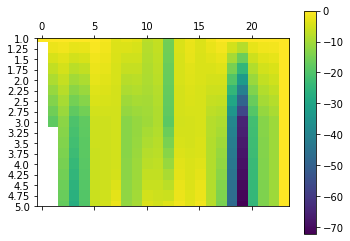

In [22]:
# Visualize optimal value dispatch in each hour.
plt.matshow(batteryBackwardsPass)
plt.gca().set_yticks(range(len(batteryBackwardsPass.index)))
plt.gca().set_yticklabels(batteryBackwardsPass.index)
plt.colorbar()
plt.show()

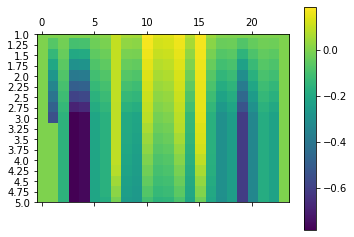

In [23]:
# Visualize optimal expected dispatch in each hour.
plt.matshow(optimalPath)
plt.gca().set_yticks(range(len(optimalPath.index)))
plt.gca().set_yticklabels(optimalPath.index)
plt.colorbar()
plt.show()